ARMA is a model in which AR model and MA model are combined together.
$$r_{t}=c+\sum_{i=1}^{n}\phi_{i}r_{t-i}+\sum_{i=1}^{p}\theta_i\epsilon_{t-i}+\epsilon_t$$
$\phi_i$ : The importance of the value for the i-th lag
$\theta_i$ : The importance of the error terms for the i-th lag.
$ARMA(AR, \space MA)$

## Importing relevant packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from math  import sqrt
import seaborn as sns
from google.colab import drive
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


## Importing the Data and Pre-Processing

In [5]:
raw_csv_data = pd.read_csv("/content/drive/MyDrive/Formations/Time Series/Index2018.csv", index_col="date", parse_dates=True, dayfirst=True)
df_comp = raw_csv_data.copy()
df_comp = df_comp.asfreq("b")
df_comp = df_comp.fillna(method="ffill")

In [6]:
df_comp["market_value"] = df_comp.ftse

In [7]:
df_comp.drop(columns=["spx", "dax", "ftse", "nikkei"], inplace=True)
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp[size:]

## The LLR Test

In [8]:
"""mod_1, mod_2 : models we want to compare
DF : degrees of freedom"""
def LLR_test(mod_1, mod_2, DF=1):
  L1 = mod_1.fit().llf 
  L2 = mod_2.fit().llf
  LR = 2*(L2-L1) 
  p = chi2.sf(LR, DF).round(3)
  return p 

## Creating Returns

In [9]:
df["returns"] = df.market_value.pct_change(1)*100

## ARMA(1, 1)
Since we are using returns the constant is approximatively around $0$.

### Interpretation 
* **Positive AR coefficient :** 
  * There is a positive tendency between past and present values.
  * Returns move in trends of consecutive positive or negative values.
  * Periods of persistent increase or decreases when translated to prices.

* **Negative MA coefficient :** It's slightlt harder to interpret.
  * We should be moving away from the past period (t-1) values.
  * These past error terms ensure we don't get a "Fool in the shower" type of error.

In [11]:
model_ret_ar_1_ma_1 = ARIMA(df.returns[1:], order=(1, 0, 1))
results_ret_ar_1_ma_1 = model_ret_ar_1_ma_1.fit()
results_ret_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7916.500
Date:                Tue, 28 Mar 2023   AIC                          15841.000
Time:                        11:52:49   BIC                          15867.085
Sample:                    01-10-1994   HQIC                         15850.140
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.290      0.197      -0.010       0.048
ar.L1          0.7650      0.045     16.995      0.000       0.677       0.853
ma.L1         -0.8142      0.040    -20.187      0.000      -0.893      -0.735
sigma2         1.3718      0.014     98.110      0.000       1.344       1.399
===================================================================================
Ljung-Box (L1) (Q):                   2.06   Jarque-Bera (JB):              7488.92
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
model_ret_ar_1 = ARIMA(df.returns, order=(1, 0, 0))
model_ret_ma_1 = ARIMA(df.returns, order=(0, 0, 1))

In [14]:
print("ARMA vs AR ", LLR_test(model_ret_ar_1, model_ret_ar_1_ma_1))
print("ARMA vs MA ", LLR_test(model_ret_ma_1, model_ret_ar_1_ma_1))

ARMA vs AR  0.0
ARMA vs MA  0.0


## Higher-Lag ARMA Models
We use fewer lags because 
* Allow AR models to callibrate faster and ajust to some huge shocks.
* Give MA terms a much better foundation for predictions.

We stop iterating when :
1. All coefficient significant
2. High Log-Likelihood
3. Low information criteria

We often start with an over-parameterized model. In this example $ARMA(8, 6)$. Since half of the coefficients are significantly different from $0$, we choose the half of the model $ARMA(4, 3)$. But starting with simpler $ARMA(3,3)$ sounds all the more sensible.


---


* After fitting the model, we have obtained the constant which is significantly different from $0$. That suggests that the lower model will be better use.
* After checking the LLR test, the $ARMA(3, 3)$ fits better than $ARMA(1, 1)$.
* If $ARMA(3, 3)$ is not the optimum one, we expect the best one between $[ARMA(1, 1); ARMA(3, 3)]$.
* We can lower $AR$ orders and $MA$ orders for both. But how will we decide from which one do we start.
* We begin with the models that consist of $5$ total orders $(AR+MA)$.

In [21]:
model_ret_ar_3_ma_3 = ARIMA(df.returns[1:], order=(3, 0, 3))
results_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()
print(results_ret_ar_3_ma_3.summary())
print(LLR_test(model_ret_ar_1_ma_1, model_ret_ar_3_ma_3, DF=4))


                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -7893.515
Date:                Tue, 28 Mar 2023   AIC                          15803.030
Time:                        13:39:32   BIC                          15855.200
Sample:                    01-10-1994   HQIC                         15821.311
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.281      0.200      -0.010       0.048
ar.L1         -0.1880      0.068     -2.780      0.005      -0.321      -0.055
ar.L2         -0.2926      0.054     -5.380      0.0

* The constant being $0$ shouldn't bother us our model returns, because returns in an efficient market should be $0$ anyway.
* None of the p-values for this model are troublesome.
* We can notice how as the lags increase, the absolute values of the $AR$ as well as the $MA$ coefficients decrease. This supports the idea that the further back in time we go, the less relevant the values and errors become. Of course this is not necessarily hold true for every model, but such a trend makes our predictions seem much more realistic.
* Positive $MA$ coefficients suggest calibration efforts.

In [20]:
model_ret_ar_3_ma_2 = ARIMA(df.returns[1:], order=(3, 0, 2))
results_ret_ar_3_ma_2 = model_ret_ar_3_ma_2.fit()
print(results_ret_ar_3_ma_2.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -7895.747
Date:                Tue, 28 Mar 2023   AIC                          15805.495
Time:                        13:39:21   BIC                          15851.143
Sample:                    01-10-1994   HQIC                         15821.491
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.211      0.226      -0.012       0.049
ar.L1         -0.6778      0.055    -12.298      0.000      -0.786      -0.570
ar.L2         -0.5082      0.063     -8.035      0.0

$\theta_i>0$ :
* If our model prediction was lower than the actual value, we'd get a positive residual value, thus :
$$\epsilon_t>0\implies\theta\epsilon_t>0$$
This results in an increase in the value of our predictions for the next period. So we try to close the gap to the actual value hoping the pattern will be translate into the future.
* Similarly, if our predictions are higher than the true values for that period, the residual will be negative, thus :
$$\epsilon_t<0\implies\theta\epsilon_t<0$$
Therefore our next prediction would be lower, so once again trying to get closer to the actual values

$\phi_i<0$ :
$$r_{t-i}>0\implies\phi_i r_{t-i}<0$$
We expect an efficient market to have a mean of zero over time. Therefore, every period of positive returns is followed by one with negative returns. The assumption is tat it allows us to remain close to the mean of $0$ regardless of the starting and ending periods in our sample ($AR$ models are good for stationary data). 

In [22]:
model_ret_ar_2_ma_3 = ARIMA(df.returns[1:], order=(2, 0, 3))
results_ret_ar_2_ma_3 = model_ret_ar_2_ma_3.fit()
print(results_ret_ar_2_ma_3.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -7895.587
Date:                Tue, 28 Mar 2023   AIC                          15805.175
Time:                        13:39:51   BIC                          15850.823
Sample:                    01-10-1994   HQIC                         15821.170
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.015      1.224      0.221      -0.011       0.049
ar.L1         -0.5600      0.057     -9.777      0.000      -0.672      -0.448
ar.L2         -0.4178      0.065     -6.381      0.0

We should opt for the $ARMA(3, 3)$ model instead of the $ARMA(2, 3)$ one if we had to choose ***only*** between these two. Fortunately, there are multiple other models that we can try.

In [24]:
LLR_test(model_ret_ar_2_ma_3, model_ret_ar_3_ma_3)

0.042

In [25]:
model_ret_ar_3_ma_1 = ARIMA(df.returns[1:], order=(3, 0, 1))
results_ret_ar_3_ma_1 = model_ret_ar_3_ma_1.fit()
print(results_ret_ar_3_ma_1.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(3, 0, 1)   Log Likelihood               -7899.072
Date:                Tue, 28 Mar 2023   AIC                          15810.144
Time:                        13:45:33   BIC                          15849.271
Sample:                    01-10-1994   HQIC                         15823.855
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.248      0.212      -0.011       0.048
ar.L1         -0.5074      0.062     -8.155      0.000      -0.629      -0.385
ar.L2         -0.0638      0.009     -7.027      0.0

In [26]:
LLR_test(model_ret_ar_3_ma_1, model_ret_ar_3_ma_2)

0.01

* Two coefficient are non significant. That leads us to believe that simpler models like the $ARMA(1, 2)$ or the $ARMA(2, 1)$ would outperform it ($ARMA(2, 2)$).
* We should avoid $ARMA(2, 2)$ at all costs.

In [27]:
model_ret_ar_2_ma_2 = ARIMA(df.returns[1:], order=(2, 0, 2))
results_ret_ar_2_ma_2 = model_ret_ar_2_ma_2.fit()
print(results_ret_ar_2_ma_2.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7914.692
Date:                Tue, 28 Mar 2023   AIC                          15841.384
Time:                        13:47:38   BIC                          15880.511
Sample:                    01-10-1994   HQIC                         15855.095
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.290      0.197      -0.010       0.048
ar.L1         -0.0969      0.091     -1.068      0.286      -0.275       0.081
ar.L2          0.6975      0.066     10.509      0.0

Usually, we'll go on tu use the Log-likelihood ratio test here to comparre it with the $ARMA(3, 2)$.

In [29]:
model_ret_ar_1_ma_3 = ARIMA(df.returns[1:], order=(1, 0, 3))
results_ret_ar_1_ma_3 = model_ret_ar_1_ma_3.fit()
print(results_ret_ar_1_ma_3.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -7896.838
Date:                Tue, 28 Mar 2023   AIC                          15805.676
Time:                        13:50:46   BIC                          15844.803
Sample:                    01-10-1994   HQIC                         15819.386
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.265      0.206      -0.010       0.048
ar.L1         -0.4693      0.060     -7.878      0.000      -0.586      -0.353
ma.L1          0.4469      0.060      7.437      0.0

### Models of interest
Suppose we have two models :
$ARMA(P_1, Q_1)$ and $ARMA(P_2, Q_2)$
The second moel is **nested** if only if :
1. $P_1+Q_1>P_2+Q_2$
2. $P_1\geq P_2$
3. $Q_1\geq Q_2$

If only one condition is not satisfied, the LLR-test will we incorrect. In this case, we manually compare the Log-Likelihoods and AICs of both models. We choose the one who has Higher LLR and lower AIC.

In [34]:
print(f"ARMA(3, 2) \tLLR = {results_ret_ar_3_ma_2.llf} \tAIC = {results_ret_ar_3_ma_2.aic}")
print(f"ARMA(1, 3) \tLLR = {results_ret_ar_1_ma_3.llf} \tAIC = {results_ret_ar_1_ma_3.aic}")


ARMA(3, 2) 	LLR = -7895.747490025735 	AIC = 15805.49498005147
ARMA(1, 3) 	LLR = -7896.83790920579 	AIC = 15805.67581841158


From, the previous result, we go for $ARMA(3, 2)$ because of :
1. All significant coefficients.
2. Outpredicts all less-complex alternatives. 

## Residuals for Returns
* the volatility in returns might not be fully comprehendable if we use only ARMA models.

In [36]:
df["res_ret_ar_3_ma_2"] = results_ret_ar_3_ma_2.resid[1:]

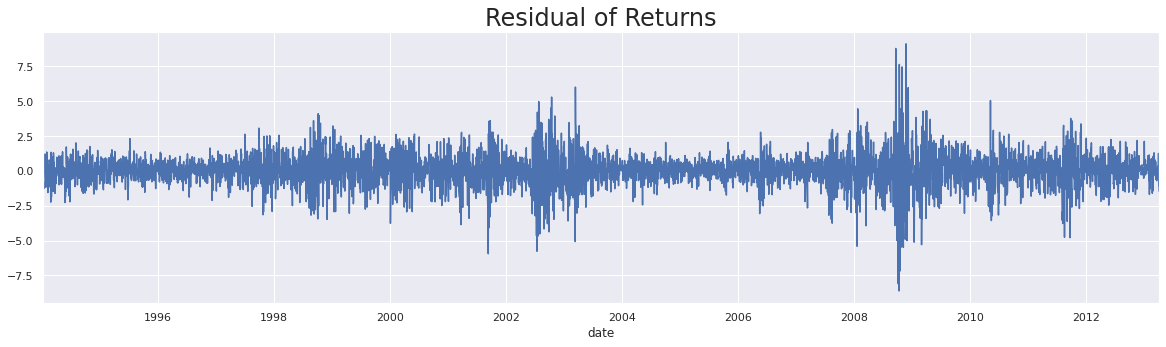

In [37]:
df.res_ret_ar_3_ma_2.plot(figsize=(20, 5))
plt.title("Residual of Returns", size=24)
plt.show()

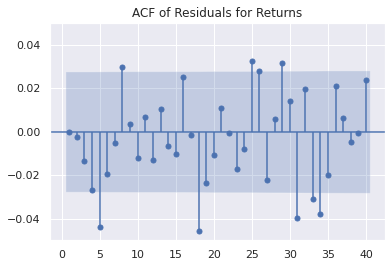

In [39]:
sgt.plot_acf(df.res_ret_ar_3_ma_2[2:], zero=False, lags=40)
plt.title("ACF of Residuals for Returns")
plt.ylim(-0.05, 0.05)
plt.show()

* It's somehow surprising to see we have more significant lags than AR and MA models. 
* the 5-th lag was incorporated into both the AR only and MA only models, so it makes sense for its error term to be essentially zero.
* Accounting for either returns or residuals 5 periods ago, could improve our predictions.

## Reevaluating Model Selection
* Taking both returns and residuals 5 periods ago is redundant.
* We should only focus on one of the two.

In [41]:
model_ret_ar_5_ma_5 = ARIMA(df.returns[1:], order=(5, 0, 5))
results_ret_ar_5_ma_5 = model_ret_ar_5_ma_5.fit()
print(results_ret_ar_5_ma_5.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -7882.752
Date:                Tue, 28 Mar 2023   AIC                          15789.504
Time:                        14:33:19   BIC                          15867.758
Sample:                    01-10-1994   HQIC                         15816.925
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0209      0.015      1.408      0.159      -0.008       0.050
ar.L1         -0.0894      0.117     -0.765      0.444      -0.318       0.140
ar.L2         -0.5564      0.081     -6.851      0.0

In [42]:
model_ret_ar_5_ma_1 = ARIMA(df.returns[1:], order=(5, 0, 1))
results_ret_ar_5_ma_1 = model_ret_ar_5_ma_1.fit()
print(results_ret_ar_5_ma_1.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(5, 0, 1)   Log Likelihood               -7889.311
Date:                Tue, 28 Mar 2023   AIC                          15794.623
Time:                        14:35:46   BIC                          15846.792
Sample:                    01-10-1994   HQIC                         15812.903
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.301      0.193      -0.010       0.047
ar.L1          0.3449      0.105      3.270      0.001       0.138       0.552
ar.L2         -0.0458      0.009     -4.852      0.0

In [43]:
model_ret_ar_1_ma_5 = ARIMA(df.returns[1:], order=(1, 0, 5))
results_ret_ar_1_ma_5 = model_ret_ar_1_ma_5.fit()
print(results_ret_ar_1_ma_5.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -7890.974
Date:                Tue, 28 Mar 2023   AIC                          15797.949
Time:                        14:36:13   BIC                          15850.118
Sample:                    01-10-1994   HQIC                         15816.230
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.297      0.194      -0.010       0.047
ar.L1          0.3218      0.133      2.415      0.016       0.061       0.583
ma.L1         -0.3467      0.134     -2.593      0.0

In [44]:
print(f"ARMA(5, 1) \tLLR = {results_ret_ar_5_ma_1.llf} \tAIC = {results_ret_ar_5_ma_1.aic}")
print(f"ARMA(1, 5) \tLLR = {results_ret_ar_1_ma_5.llf} \tAIC = {results_ret_ar_1_ma_5.aic}")

ARMA(5, 1) 	LLR = -7889.311305453215 	AIC = 15794.62261090643
ARMA(1, 5) 	LLR = -7890.974434537854 	AIC = 15797.948869075708


In [45]:
print(f"ARMA(5, 1) \tLLR = {results_ret_ar_5_ma_1.llf} \tAIC = {results_ret_ar_5_ma_1.aic}")
print(f"ARMA(3, 2) \tLLR = {results_ret_ar_3_ma_2.llf} \tAIC = {results_ret_ar_3_ma_2.aic}")

ARMA(5, 1) 	LLR = -7889.311305453215 	AIC = 15794.62261090643
ARMA(3, 2) 	LLR = -7895.747490025735 	AIC = 15805.49498005147


## Residuals for the new model
* If we take more lags, this will predespose the model to failure when facing unfamiliar data.
* Including so many lags, will help us know with confidence how this specific data set moves rather than understand how the actual market returns flactuate.
* The effects of returns and errors tend to diminish over time.
* The further back in time we go, the less relevant the values are in predicting the future.
* Since more than $10$ of the first lags are not significant, we can say the residuals are pretty much random. Which is what we were trying to achieve.

In [46]:
df['res_ret_ar_5_ma_1'] = results_ret_ar_5_ma_1.resid

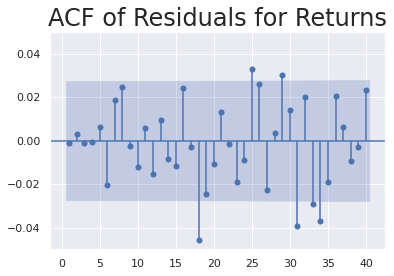

In [48]:
sgt.plot_acf(df.res_ret_ar_5_ma_1[1:], zero=False, lags=40)
plt.title("ACF of Residuals for Returns", size=24)
plt.ylim(-0.05, 0.05)
plt.show()

# ARMA Models for prices
* See how ARMA models perform when they are fed non-stationary data (Market Index Prices).

The AR and MA models fail at predicting non-stationary data on their own

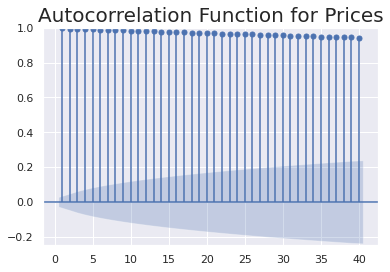

In [50]:
sgt.plot_acf(df.market_value, unbiased=True, zero=False, lags=40)
plt.title("Autocorrelation Function for Prices", size=20)
plt.ylim(-0.25, 1)
plt.show()

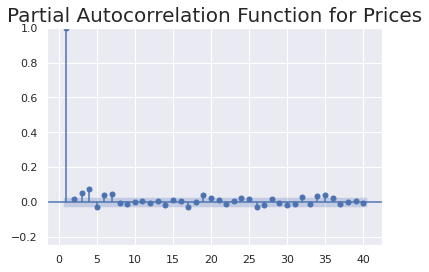

In [51]:
sgt.plot_pacf(df.market_value, alpha=0.05, zero=False, lags=40, method=('ols'))
plt.title("Partial Autocorrelation Function for Prices", size=20)
plt.ylim(-0.25, 1)
plt.show()

In [53]:
model_ar_1_ma_1 = ARIMA(df.market_value, order=(1, 0, 1))
results_ar_1_ma_1 = model_ar_1_ma_1.fit()
print(results_ar_1_ma_1.summary())

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -27621.875
Date:                Tue, 28 Mar 2023   AIC                          55251.749
Time:                        14:55:14   BIC                          55277.835
Sample:                    01-07-1994   HQIC                         55260.890
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    366.501     13.887      0.000    4371.312    5807.970
ar.L1          0.9982      0.001   1189.159      0.000       0.997       1.000
ma.L1         -0.0186      0.010     -1.894      0.0

In [54]:
df["res_ar_1_ma_1"] = results_ar_1_ma_1.resid

* We see that 5 of the first six lags are significant, so we must amend this.
* Accounting for up to that many lags in our model.

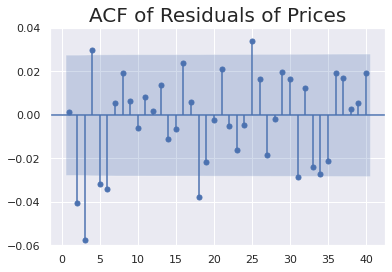

In [58]:
sgt.plot_acf(df.res_ar_1_ma_1, zero=False, lags=40)
plt.title("ACF of Residuals of Prices", size=20)
plt.ylim(-0.06, 0.04)
plt.show()

### If you use old version 
If the computed initial AR coefficients are not stationary, we can opt for one of these three solutions :
* Inducing stationarity which we do by transforming the data into returns
* Choosing different order which we wanna avoid because we are interested in the coefficients for (6, 6).
* Setting the initial parameters by setting `start_ar_lags` argument in the `fit` method. The values that we should introduce need to be greater than the AR order of the model. If the problem persists, we'll contnue to increase the number until we get the summerize table.
---

* We see that some of the coefficients are not significant, so we should lower the total number of lags and conduct a trial and error approach. That means we should try all models which contain either 6 AR lags or 6 MA lags.

They perform much worse compared to their ability to estimate stationary data.

In [61]:
model_ar_6_ma_6 = ARIMA(df.market_value, order=(6, 0, 6))
results_ar_6_ma_6 = model_ar_6_ma_6.fit()
print(results_ar_6_ma_6.summary())

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(6, 0, 6)   Log Likelihood              -27591.277
Date:                Tue, 28 Mar 2023   AIC                          55210.553
Time:                        15:23:12   BIC                          55301.853
Sample:                    01-07-1994   HQIC                         55242.546
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6408    511.854      9.944      0.000    4086.426    6092.855
ar.L1          0.7382      0.927      0.796      0.426      -1.078       2.555
ar.L2          0.2445      1.556      0.157      0.8

In [62]:
model_ar_5_ma_6 = ARIMA(df.market_value, order=(5, 0, 6))
results_ar_5_ma_6 = model_ar_5_ma_6.fit()
print(results_ar_5_ma_6.summary())

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(5, 0, 6)   Log Likelihood              -27589.851
Date:                Tue, 28 Mar 2023   AIC                          55205.703
Time:                        15:26:30   BIC                          55290.481
Sample:                    01-07-1994   HQIC                         55235.410
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6408   1620.722      3.140      0.002    1913.085    8266.197
ar.L1          0.6072      0.619      0.980      0.327      -0.607       1.821
ar.L2         -0.2239      0.705     -0.318      0.7

In [69]:
model_ar_6_ma_1 = ARIMA(df.market_value, order=(5, 0, 6))
results_ar_6_ma_1 = model_ar_6_ma_1.fit()
print(results_ar_6_ma_1.summary())

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(5, 0, 6)   Log Likelihood              -27589.851
Date:                Tue, 28 Mar 2023   AIC                          55205.703
Time:                        15:30:58   BIC                          55290.481
Sample:                    01-07-1994   HQIC                         55235.410
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6408   1620.722      3.140      0.002    1913.085    8266.197
ar.L1          0.6072      0.619      0.980      0.327      -0.607       1.821
ar.L2         -0.2239      0.705     -0.318      0.7

In [66]:
print(f"ARMA(5, 6) \tLLR = {results_ar_5_ma_6.llf} \tAIC = {results_ar_5_ma_6.aic}")
print(f"ARMA(6, 1) \tLLR = {results_ar_6_ma_1.llf} \tAIC = {results_ar_6_ma_1.aic}")

ARMA(5, 6) 	LLR = -27589.851402209897 	AIC = 55205.702804419794
ARMA(6, 1) 	LLR = -27589.851402209897 	AIC = 55205.702804419794
